# Spotify Recommendation System

In [36]:
# Import libraries
import pandas as pd
import numpy as np
import json
import csv
import spotipy
import spotipy.oauth2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Read in data
file = 'mpd.slice.0-999.json'

playlist_fields = ['pid','name', 'collaborative', 'modified_at', 'num_albums', 'num_tracks', 'num_followers',
'num_tracks', 'num_edits', 'duration_ms', 'num_artists','description']
track_fields = ['tid', 'arid' , 'alid', 'track_uri', 'track_name', 'duration_ms']
album_fields = ['alid','album_uri','album_name']
artist_fields = ['arid','artist_uri','artist_name']
interaction_fields = ['pid','tid','pos']
interactions = []
playlists = []
tracks = []
artists = []
albums = []
count_files = 0
count_playlists = 0
count_interactions = 0
count_tracks = 0
count_artists = 0
count_albums = 0
dict_tracks = {}
dict_artists = {}
dict_albums = {}


def process_mpd(file):
    global count_playlists
    global count_files
    f = open(file)
    js = f.read()
    f.close()
    mpd_slice = json.loads(js)
    process_info(mpd_slice['info'])
    for playlist in mpd_slice['playlists']:
        process_playlist(playlist)
        pid = playlist['pid']
        for track in playlist['tracks']:
            track['pid']=pid
            new = add_id_artist(track)
            if new: process_artist(track)
            new = add_id_album(track)
            if new: process_album(track)
            new = add_id_track(track)
            if new: process_track(track)
            process_interaction(track)
        count_playlists += 1
    count_files +=1

    show_summary()
    
def process_info(value):
    #print (json.dumps(value, indent=3, sort_keys=False))
    pass

def add_id_track(track):
    global count_tracks
    if track['track_uri'] not in dict_tracks:
        dict_tracks[track['track_uri']] = count_tracks
        track['tid'] = count_tracks
        count_tracks += 1
        return True
    else:
        track['tid'] = dict_tracks[track['track_uri']]
        return False

def add_id_artist(track):
    global count_artists
    if track['artist_uri'] not in dict_artists:
        dict_artists[track['artist_uri']] = count_artists
        track['arid'] = count_artists
        count_artists += 1
        return True
    else:
        track['arid'] = dict_artists[track['artist_uri']]
        return False

def add_id_album(track):
    global count_albums
    if track['album_uri'] not in dict_albums:
        dict_albums[track['album_uri']] = count_albums
        track['alid'] = count_albums
        count_albums += 1
        return True
    else:
        track['alid'] = dict_albums[track['album_uri']]
        return False

def process_track(track):
    global track_fields
    info = []
    for field in track_fields:
        info.append(track[field])
    tracks.append(info)

def process_album(track):
    global album_fields
    info = []
    for field in album_fields:
        info.append(track[field])
    albums.append(info)

def process_artist(track):
    global artist_fields
    info = []
    for field in artist_fields:
        info.append(track[field])
    artists.append(info)

def process_interaction(track):
    global interaction_fields
    global count_interactions
    info = []
    for field in interaction_fields:
        info.append(track[field])
    interactions.append(info)
    count_interactions +=1

def process_playlist(playlist):
    global playlist_fields
    if not 'description' in playlist:
        playlist['description'] = None
    info = []
    for field in playlist_fields:
        info.append(playlist[field])
    playlists.append(info)
    
    
        
def show_summary():
    print (count_files)
    print (count_playlists)
    print (count_tracks)
    print (count_artists)
    print (count_albums)
    print (count_interactions)


process_mpd(file)

with open("artists.csv", "w", encoding='utf-8') as f:
    writer = csv.writer(f,delimiter = "\t",)
    writer.writerow(artist_fields)
    writer.writerows(artists)
print ("artists.csv done")

with open("albums.csv", "w", encoding='utf-8') as f:
    writer = csv.writer(f,delimiter = "\t",)
    writer.writerow(album_fields)
    writer.writerows(albums)
print ("albums.csv done")
    
with open("train_interactions.csv", "w", encoding='utf-8') as f:
    writer = csv.writer(f,delimiter = "\t",)
    writer.writerow(interaction_fields)
    writer.writerows(interactions)
print ("train_interactions.csv done")

with open("tracks.csv", "w", encoding='utf-8') as f:
    writer = csv.writer(f,delimiter = "\t",)
    writer.writerow(track_fields)
    writer.writerows(tracks)
print ("tracks.csv done")

with open("train_playlists.csv", "w", encoding='utf-8') as f:
    writer = csv.writer(f,delimiter = "\t",)
    writer.writerow(playlist_fields)
    writer.writerows(playlists)
print ("train_playlists.csv done")

1
1000
34443
9754
19261
67503
artists.csv done
albums.csv done
train_interactions.csv done
tracks.csv done
train_playlists.csv done


In [3]:
# Retreieve track audio features from Spotify API
creds = pd.read_json('spotify_creds.json')
clientID = creds['clientID'][0]
clientSecret = creds['clientSecret'][0]

# Prepare spotipy api
credentials = spotipy.oauth2.SpotifyClientCredentials(client_id=clientID,
                                                     client_secret=clientSecret)
spotify = spotipy.Spotify(client_credentials_manager=credentials)

# Load targht tracks
tracks = pd.read_csv('tracks.csv', sep='\t')
uris = tracks[['track_uri']]

# Download audio features
audioDict = {}
for uri in tqdm(uris.track_uri, desc='Downloading audio features'):
    audioDict[uri] = spotify.audio_features(uri)
    
# Build dataframe for audio feats
feats = ['acousticness','danceability','energy','instrumentalness',
             'liveness','loudness','speechiness','tempo','valence','key','mode',
             'time_signature']
uriList = []
featLists = {}
for feat in feats:
    featLists[feat] = []
for key in tqdm(audioDict.keys(), desc='Building dataframe'):
    uri = key
    audio = audioDict[key]
    if audio[0]:
        uriList.append(key)
        feat_dict = audio[0]
        for feat in feats:
            featLists[feat].append(feat_dict[feat])
    else:
        pass
audio_df = pd.DataFrame()
audio_df['track_uri'] = uriList
for feat in feats:
    audio_df[feat] = featLists[feat]

audio_df.head()
    
# Merge info
tracks = tracks.merge(audio_df, left_on='track_uri', right_on='track_uri', how='left')

# Fill missing value
tracks = tracks.fillna(0)

# Dump dataframe
print('Saving data to "tracks_v2.csv"')
tracks.to_csv('tracks_v2.csv', sep='\t', index=False)

Building dataframe: 100%|██████████| 34443/34443 [00:00<00:00, 371349.95it/s]


Saving data to "tracks_v2.csv"


In [124]:
# Read in created CSVs
albums = pd.read_csv('albums.csv', delimiter='\t')
print('Albums: ', albums.shape)

artists = pd.read_csv('artists.csv', delimiter='\t')
print('Artists: ', artists.shape)

tracks = pd.read_csv('tracks_v2.csv', delimiter='\t')
print('Tracks: ', tracks.shape)

interactions = pd.read_csv('train_interactions.csv', delimiter='\t')
print('Interactions: ', interactions.shape)

playlists = pd.read_csv('train_playlists.csv', delimiter='\t')
playlists = playlists.drop(['num_tracks.1'], axis=1)
print('Playlists: ', playlists.shape)

tracks = pd.merge(tracks, albums, how='inner', on='alid')
tracks = pd.merge(tracks, artists, how='inner', on='arid')

Albums:  (19261, 3)
Artists:  (9754, 3)
Tracks:  (34443, 18)
Interactions:  (67503, 3)
Playlists:  (1000, 11)


## Playlist Exploration

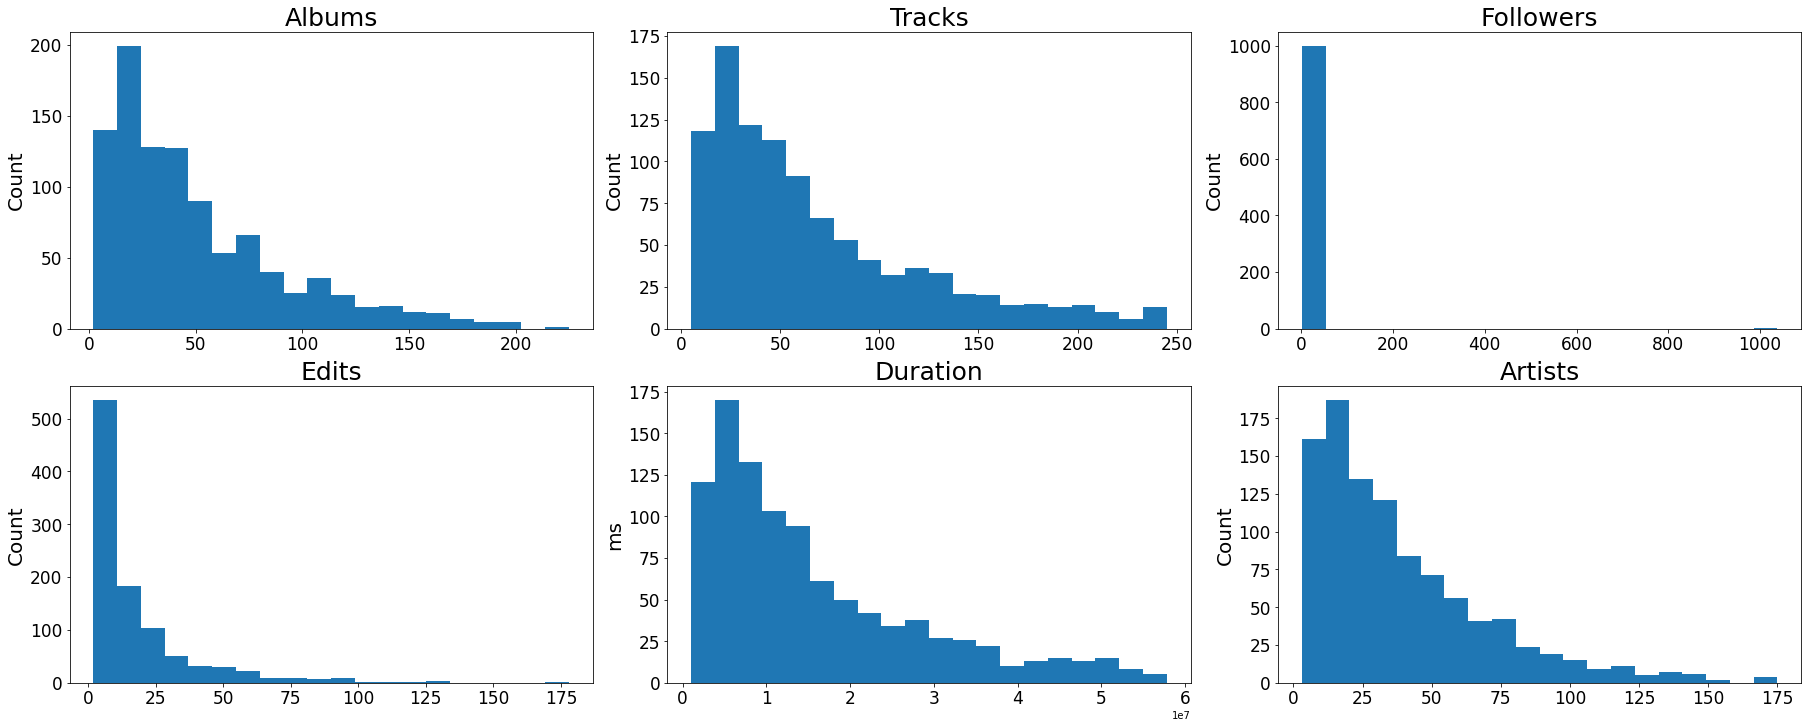

In [13]:
# Histograms
# set up the figure size
plt.rcParams['figure.figsize'] = (25, 10)

# make subplots
fig, axes = plt.subplots(nrows = 2, ncols = 3, constrained_layout=True)

# Specify the features of interest
num_features = ['num_albums','num_tracks', 'num_followers', 'num_edits','duration_ms', 'num_artists']
xaxes = num_features
titles = ['Albums','Tracks', 'Followers', 'Edits','Duration', 'Artists']
yaxes = ['Count', 'Count', 'Count', 'Count', 'ms', 'Count']

# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.hist(playlists[num_features[idx]].dropna(), bins=20)
    ax.set_title(titles[idx], fontsize=25)
    #ax.set_xlabel(xaxes[idx], fontsize=20)
    ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.tick_params(axis='both', labelsize=17)

plt.show()

In [125]:
playlists.describe()

,pid,modified_at,num_albums,num_tracks,num_followers,num_edits,duration_ms,num_artists
count,1000.000000,1.000000e+03,1000.000000,1000.00000,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,499.500000,1.476247e+09,50.526000,67.50300,2.583000,17.546000,1.574061e+07,38.746000
std,288.819436,3.719567e+07,41.448997,55.00334,32.813501,20.978751,1.290575e+07,31.245091
min,0.000000,1.322611e+09,2.000000,5.00000,1.000000,2.000000,1.002971e+06,3.000000
25%,249.750000,1.459944e+09,19.000000,25.00000,1.000000,4.000000,5.810390e+06,16.000000
50%,499.500000,1.491048e+09,38.000000,50.00000,1.000000,10.000000,1.163116e+07,30.000000
75%,749.250000,1.505779e+09,70.000000,92.50000,1.250000,22.000000,2.181915e+07,53.000000
max,999.000000,1.509494e+09,225.000000,245.00000,1038.000000,178.000000,5.781713e+07,175.000000


In [126]:
# Check nulls
print('Number of null values in each column:')
playlists.isna().sum().sort_values(ascending=False)

Number of null values in each column:


description      980
pid                0
name               0
collaborative      0
modified_at        0
num_albums         0
num_tracks         0
num_followers      0
num_edits          0
duration_ms        0
num_artists        0
dtype: int64

## Tracks exploration

In [18]:
pd.set_option('display.max_columns', None)
tracks.head()

,tid,arid,alid,track_uri,track_name,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,time_signature,album_uri,album_name,artist_uri,artist_name
0,0,0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),226863,0.0311,0.904,0.813,0.006970,0.0471,-7.105,0.121,125.461,0.810,4,0,4,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,The Cookbook,spotify:artist:2wIVse2owClT7go1WT98tk,Missy Elliott
1,5556,0,3719,spotify:track:3jagJCUbdqhDSPuxP8cAqF,Work It,263226,0.0778,0.884,0.677,0.000000,0.0732,-5.603,0.283,101.868,0.584,1,1,4,spotify:album:6DeU398qrJ1bLuryetSmup,Under Construction,spotify:artist:2wIVse2owClT7go1WT98tk,Missy Elliott
2,7104,0,3719,spotify:track:75DjPjiIp2fvJDjtt41Jfs,Gossip Folks (feat. Ludacris),234893,0.3620,0.707,0.538,0.000000,0.3170,-5.264,0.505,121.732,0.439,0,1,4,spotify:album:6DeU398qrJ1bLuryetSmup,Under Construction,spotify:artist:2wIVse2owClT7go1WT98tk,Missy Elliott
3,5614,0,3770,spotify:track:3XplJgPz8VjbDzbGwGgZdq,Get Ur Freak On,236933,0.5380,0.794,0.805,0.122000,0.0952,-6.554,0.230,177.799,0.658,0,1,4,spotify:album:6epR3D622KWsnuHye7ApOl,Respect M.E.,spotify:artist:2wIVse2owClT7go1WT98tk,Missy Elliott
4,5950,0,3997,spotify:track:0jG92AlXau21qgCQRxGLic,One Minute Man (feat. Ludacris),252986,0.0266,0.622,0.669,0.000003,0.1520,-8.419,0.329,93.839,0.570,9,1,4,spotify:album:20t54K6C80QQH7vbcpfJcP,Miss E...So Addictive,spotify:artist:2wIVse2owClT7go1WT98tk,Missy Elliott


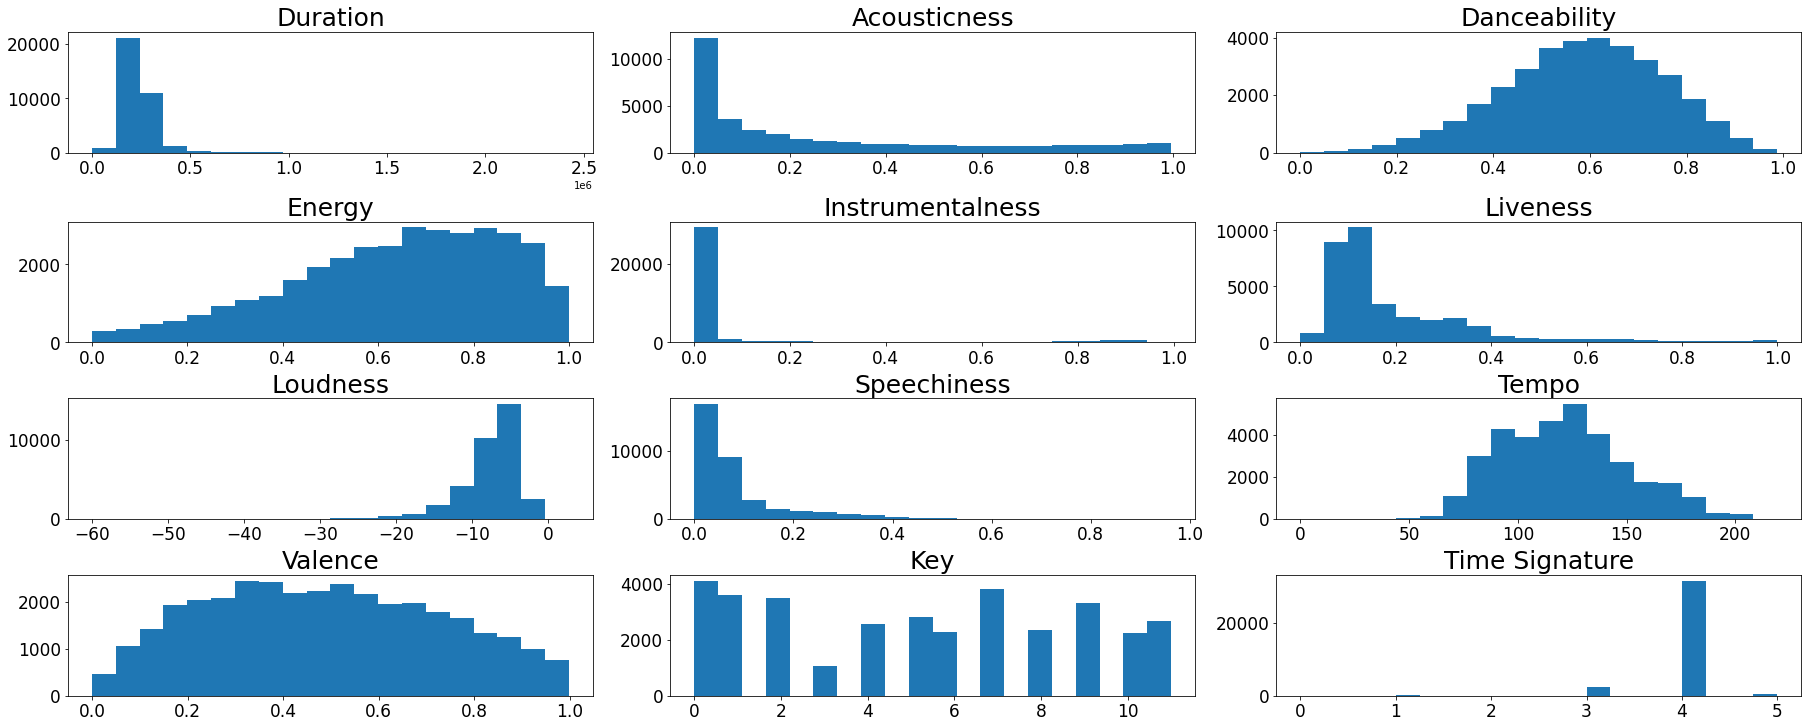

In [24]:
# Histograms
# set up the figure size
plt.rcParams['figure.figsize'] = (25, 10)

# make subplots
fig, axes = plt.subplots(nrows = 4, ncols = 3, constrained_layout=True)

# Specify the features of interest
num_features = ['duration_ms','acousticness', 'danceability', 'energy', 'instrumentalness','liveness', 'loudness', 'speechiness', 'tempo', 'valence','time_signature']
xaxes = num_features
titles = ['Duration','Acousticness', 'Danceability', 'Energy', 'Instrumentalness','Liveness', 'Loudness', 'Speechiness', 'Tempo', 'Valence','Time Signature']
#yaxes = ['ms', 'Count', 'Count', 'Count', 'ms', 'Count']

# draw histograms
axes = axes.ravel()
for idx, ax in enumerate(axes):
    ax.hist(tracks[num_features[idx]].dropna(), bins=20)
    ax.set_title(titles[idx], fontsize=25)
    #ax.set_xlabel(xaxes[idx], fontsize=20)
    #ax.set_ylabel(yaxes[idx], fontsize=20)
    ax.tick_params(axis='both', labelsize=17)

plt.show()

In [28]:
tracks.describe()

,tid,arid,alid,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,time_signature
count,34443.000000,34443.000000,34443.000000,3.444300e+04,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.00000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000,34443.000000
mean,17221.000000,3100.475626,8255.728189,2.342716e+05,0.263758,0.584726,0.636586,0.076966,0.197472,-7.60819,0.091285,121.687960,0.486125,5.214557,0.665128,3.925732
std,9942.981997,2749.544611,5687.698750,7.508022e+04,0.300530,0.164298,0.225402,0.218444,0.167388,3.96313,0.101185,29.293223,0.243578,3.584174,0.471953,0.374637
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,-60.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8610.500000,820.000000,3164.500000,1.955005e+05,0.020200,0.476000,0.490000,0.000000,0.095800,-9.17000,0.035100,98.594000,0.292000,2.000000,0.000000,4.000000
50%,17221.000000,2126.000000,7451.000000,2.247730e+05,0.126000,0.592000,0.669000,0.000008,0.128000,-6.69900,0.048900,120.858000,0.477000,5.000000,1.000000,4.000000
75%,25831.500000,5047.500000,13027.500000,2.611925e+05,0.445000,0.705000,0.818000,0.002680,0.252000,-5.00500,0.096000,140.031000,0.677000,8.000000,1.000000,4.000000
max,34442.000000,9753.000000,19260.000000,2.424189e+06,0.996000,0.988000,1.000000,0.995000,1.000000,2.76600,0.962000,219.297000,0.998000,11.000000,1.000000,5.000000


In [29]:
# Check nulls
print('Number of null values in each column:')
tracks.isna().sum().sort_values(ascending=False)

Number of null values in each column:


tid                 0
arid                0
artist_uri          0
album_name          0
album_uri           0
time_signature      0
mode                0
key                 0
valence             0
tempo               0
speechiness         0
loudness            0
liveness            0
instrumentalness    0
energy              0
danceability        0
acousticness        0
duration_ms         0
track_name          0
track_uri           0
alid                0
artist_name         0
dtype: int64

In [51]:
# Check correlation
c = tracks.corr()
c

,tid,arid,alid,duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,time_signature
tid,1.000000,0.478700,0.726979,-0.006532,0.046939,-0.036480,-0.042347,0.047574,0.011537,-0.068978,0.039894,-0.012865,-0.050184,0.002480,-0.003748,-0.006351
arid,0.478700,1.000000,0.678930,-0.037661,0.116125,-0.041062,-0.092026,0.127049,-0.024444,-0.148757,0.004748,-0.012036,-0.001877,0.002105,0.009358,-0.036355
alid,0.726979,0.678930,1.000000,-0.004038,0.067539,-0.038410,-0.051744,0.095528,0.016083,-0.105565,0.016210,-0.006672,-0.023778,0.000526,0.001270,-0.019191
duration_ms,-0.006532,-0.037661,-0.004038,1.000000,-0.081013,-0.089539,0.018379,0.065786,0.052423,-0.001943,-0.034012,-0.012059,-0.161770,-0.000245,-0.039776,0.031190
acousticness,0.046939,0.116125,0.067539,-0.081013,1.000000,-0.211177,-0.705500,0.176460,-0.065369,-0.603937,-0.068425,-0.148604,-0.181451,-0.018221,0.089414,-0.176864
danceability,-0.036480,-0.041062,-0.038410,-0.089539,-0.211177,1.000000,0.120579,-0.189037,-0.105257,0.200067,0.208833,-0.132932,0.442949,0.025016,-0.088950,0.173800
energy,-0.042347,-0.092026,-0.051744,0.018379,-0.705500,0.120579,1.000000,-0.164637,0.168877,0.776695,0.096178,0.188359,0.337263,0.026160,-0.073157,0.177152
instrumentalness,0.047574,0.127049,0.095528,0.065786,0.176460,-0.189037,-0.164637,1.000000,-0.047092,-0.340157,-0.123075,-0.029865,-0.176729,-0.010772,-0.014849,-0.065129
liveness,0.011537,-0.024444,0.016083,0.052423,-0.065369,-0.105257,0.168877,-0.047092,1.000000,0.086242,0.126372,0.017390,0.015887,-0.007976,-0.004351,0.009393
loudness,-0.068978,-0.148757,-0.105565,-0.001943,-0.603937,0.200067,0.776695,-0.340157,0.086242,1.000000,0.061014,0.147012,0.233164,0.016446,-0.051718,0.156321


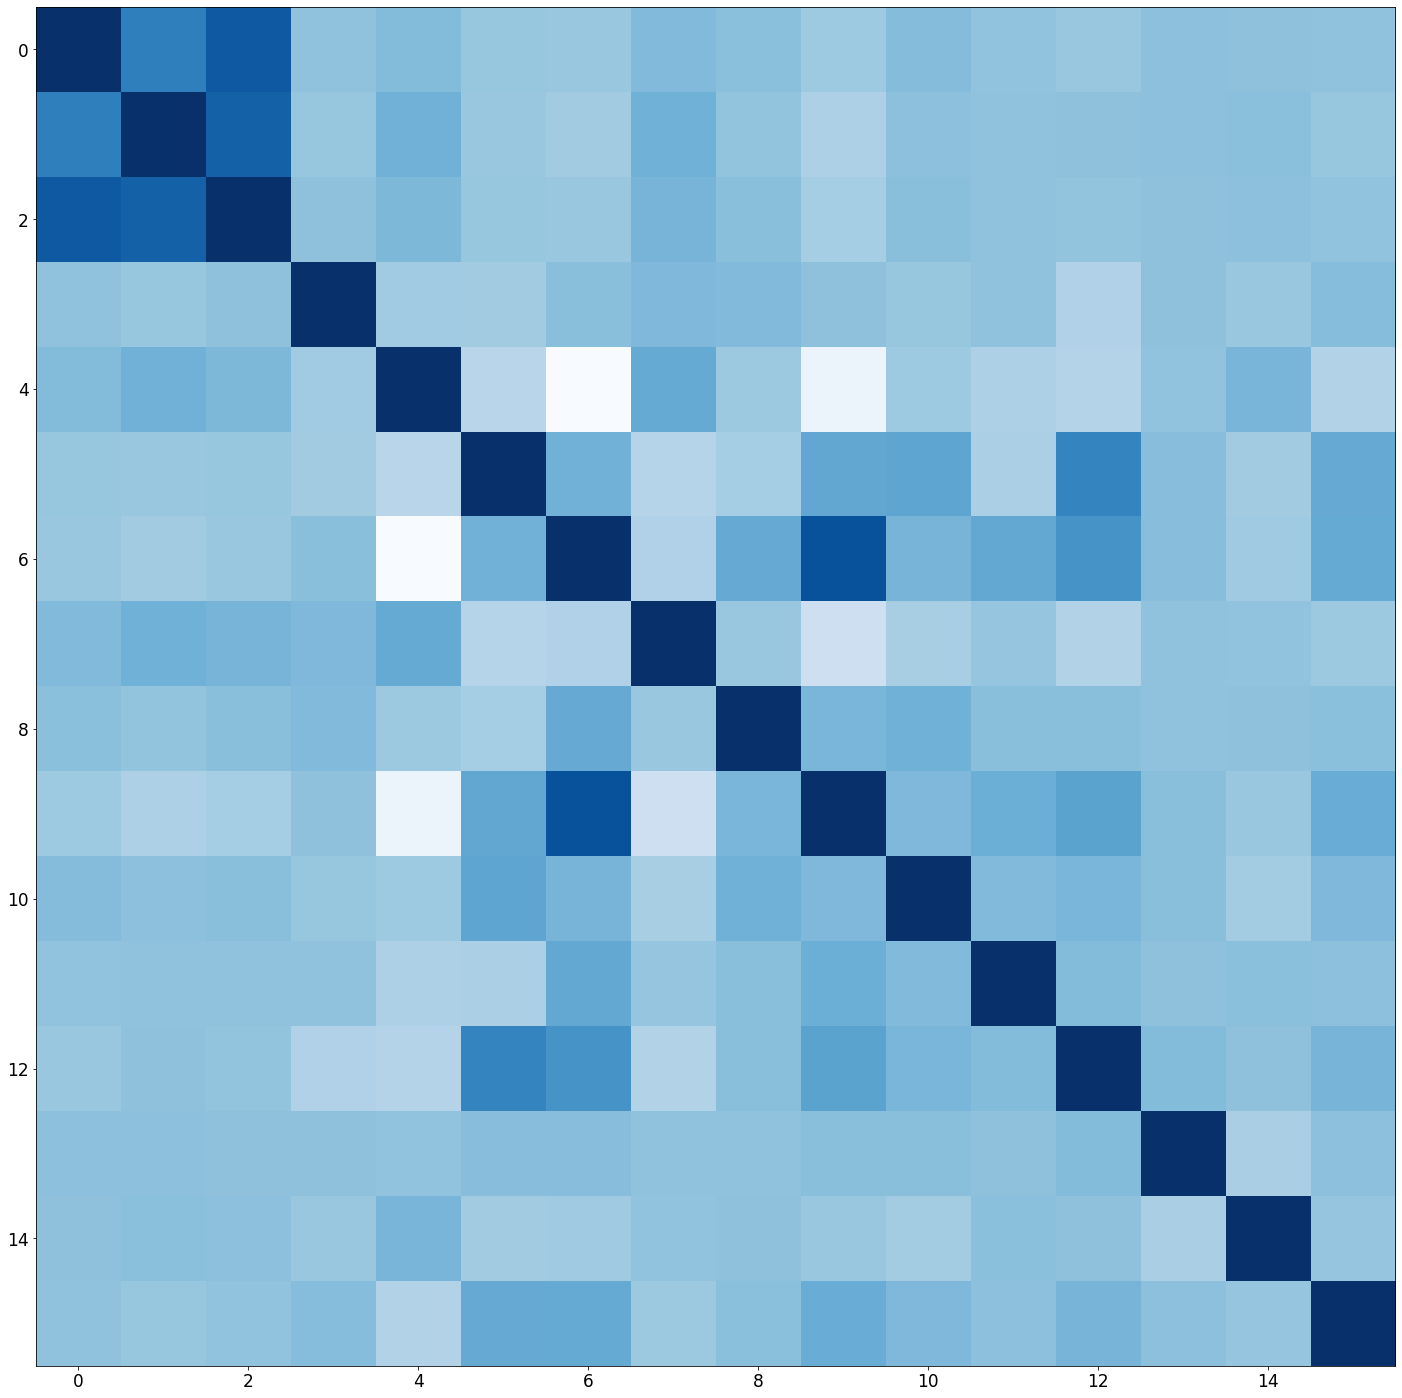

In [49]:
# Plot correlation
plt.figure(figsize=(30,25))
plt.imshow(c, cmap='Blues', interpolation='nearest')
plt.tick_params(labelsize=17)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()

Check categorical variable distributions:

In [58]:
tracks['mode'].value_counts()

1    22909
0    11534
Name: mode, dtype: int64

In [59]:
tracks['key'].value_counts()

0     4114
7     3816
1     3610
2     3516
9     3313
5     2828
11    2689
4     2565
8     2371
6     2296
10    2248
3     1077
Name: key, dtype: int64

Explore stronger relationships:

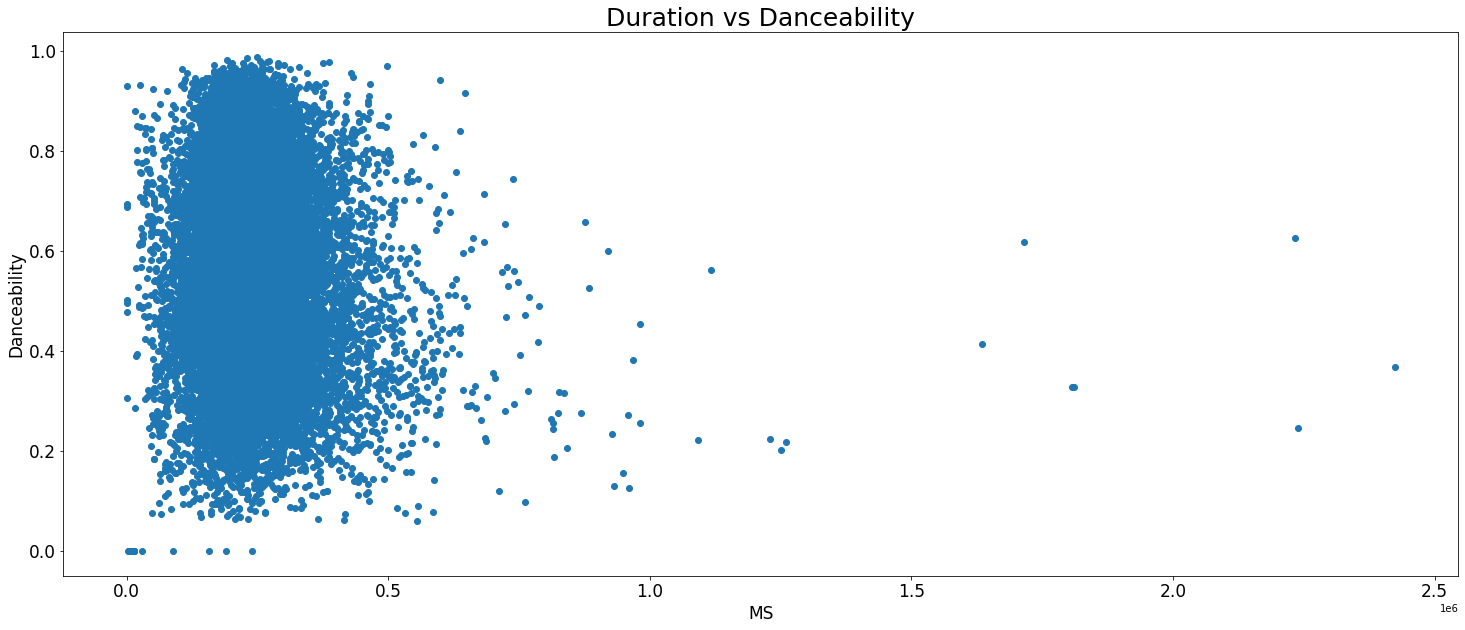

In [135]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(tracks['duration_ms']), np.array(tracks['danceability']))
plt.title('Duration vs Danceability', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('MS',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('Danceability', fontsize=17)
plt.show()

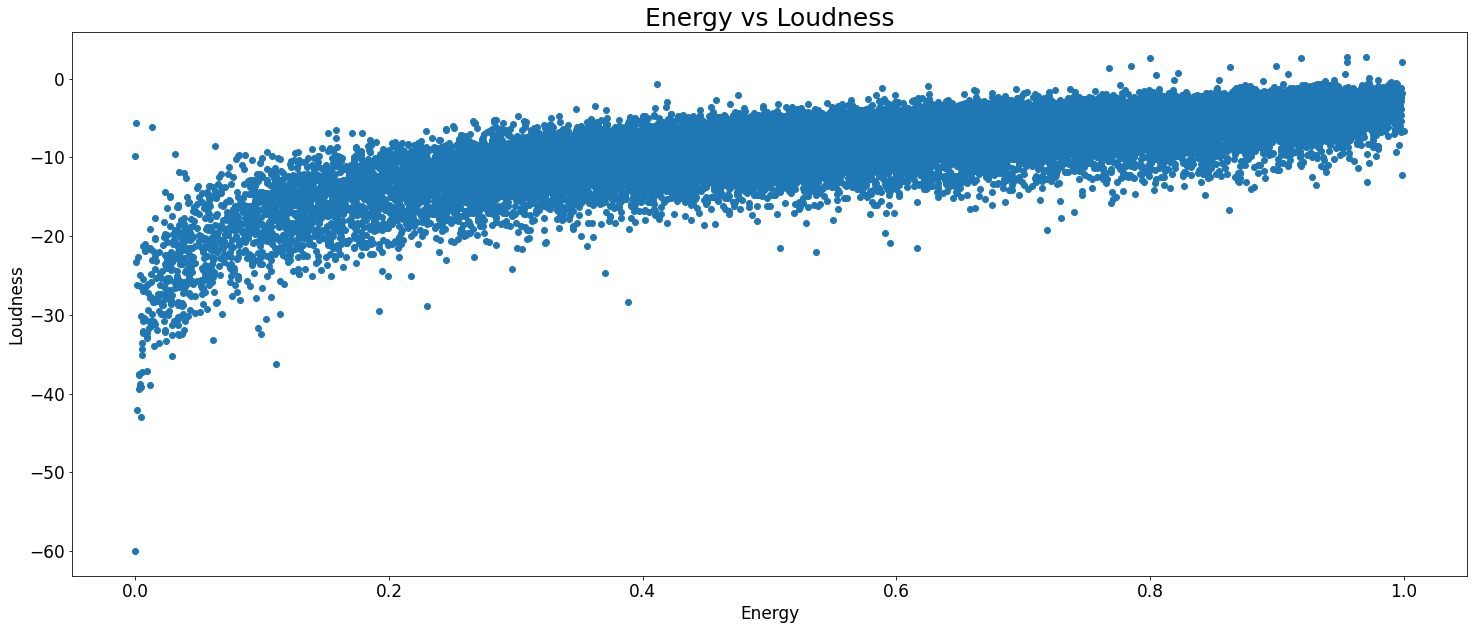

In [137]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(tracks['energy']), np.array(tracks['loudness']))
plt.title('Energy vs Loudness', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('Energy',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('Loudness', fontsize=17)
plt.show()

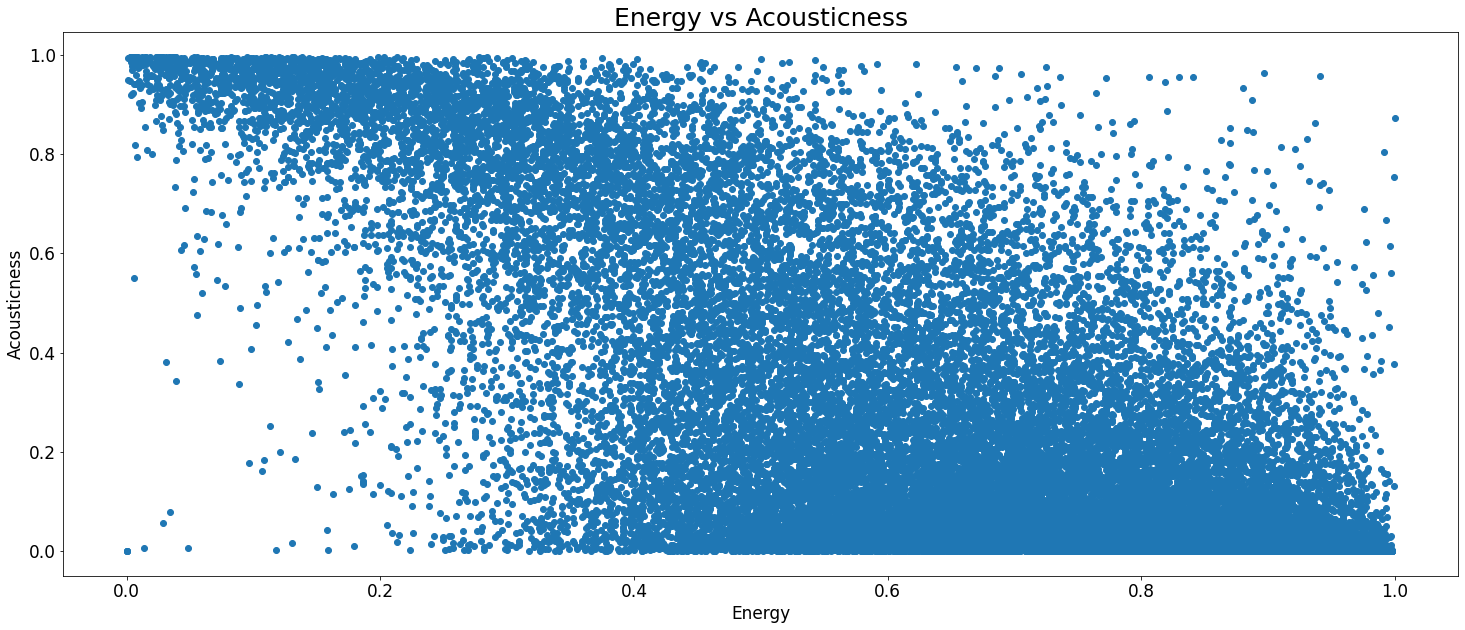

In [136]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(tracks['energy']), np.array(tracks['acousticness']))
plt.title('Energy vs Acousticness', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('Energy',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('Acousticness', fontsize=17)
plt.show()

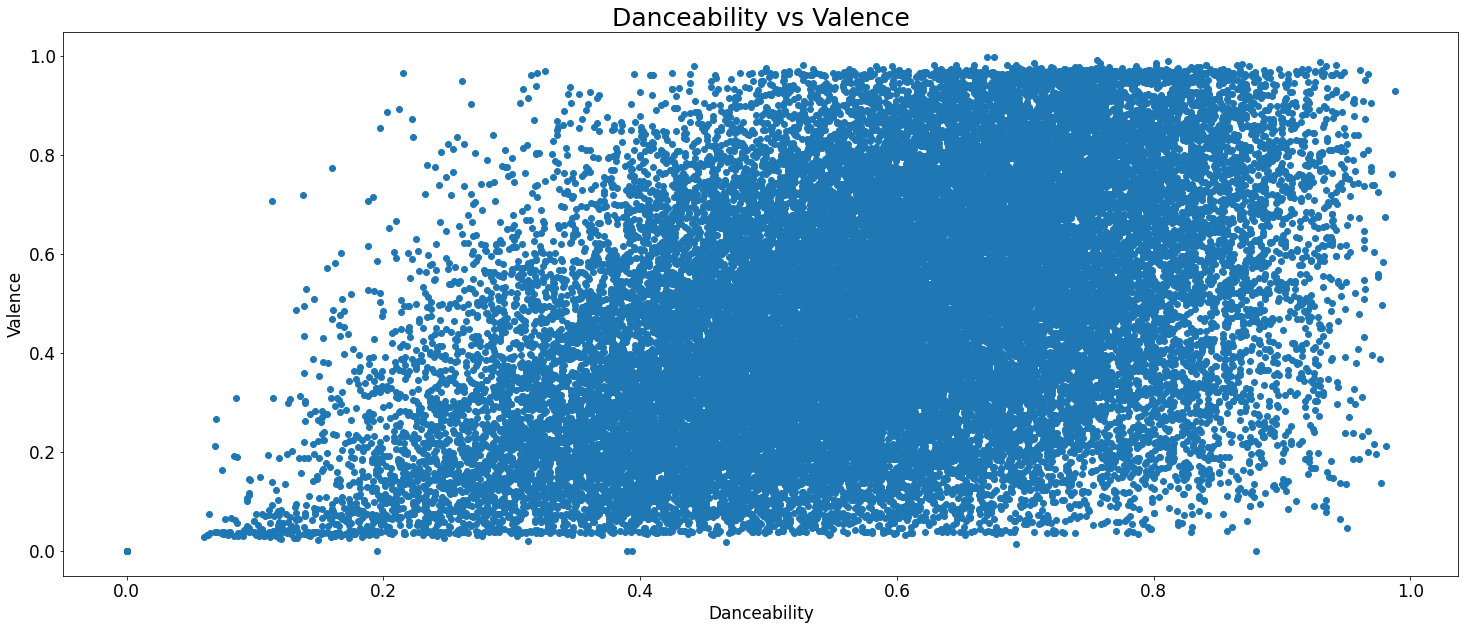

In [138]:
plt.rcParams['figure.figsize'] = (25, 10)
fig, ax = plt.subplots()

scatter = ax.scatter(np.array(tracks['danceability']), np.array(tracks['valence']))
plt.title('Danceability vs Valence', fontsize=25)
plt.xticks(fontsize=17)
plt.xlabel('Danceability',fontsize=17)
plt.yticks(fontsize=17)
plt.ylabel('Valence', fontsize=17)
plt.show()

## Feature Selection & Engineering

In [85]:
# Select features
tracks_feat = tracks[['track_uri', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key', 'mode']]

# One hot encode categorical features
tracks_feat['key'] = tracks_feat['key'].astype('str')
tracks_feat['mode'] = tracks_feat['mode'].astype('str')
cat_features = ['key', 'mode']
tracks_cat = tracks_feat[cat_features]
# One Hot Encoding 
tracks_cat_dummies = pd.get_dummies(tracks_cat)
# Join one hot encoded features back on
tracks_feat = tracks_feat.join(tracks_cat_dummies, how='left')
tracks_feat = tracks_feat.drop(cat_features, axis=1)
tracks_feat = tracks_feat.drop(['mode_1', 'key_1'], axis=1)

# Normalize numeric features
scale_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
scaler = MinMaxScaler()
tracks_num = tracks_feat[scale_features]
tracks_scaled = pd.DataFrame(scaler.fit_transform(tracks_num), columns=tracks_num.columns)
tracks_feat = tracks_feat.drop(scale_features, axis=1)
tracks_feat = tracks_feat.join(tracks_scaled, how='left')
tracks_feat.head()

C:\Users\c44519\AppData\Local\Temp\ipykernel_13796\3113791907.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_feat['key'] = tracks_feat['key'].astype('str')
C:\Users\c44519\AppData\Local\Temp\ipykernel_13796\3113791907.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_feat['mode'] = tracks_feat['mode'].astype('str')


,track_uri,key_0,key_10,key_11,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,mode_0,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,0,0,0,0,0,1,0,0,0,0,0,1,0.031225,0.914980,0.813,0.007005,0.0471,0.842733,0.125780,0.572105,0.811623
1,spotify:track:3jagJCUbdqhDSPuxP8cAqF,0,0,0,0,0,0,0,0,0,0,0,0,0.078112,0.894737,0.677,0.000000,0.0732,0.866663,0.294179,0.464521,0.585170
2,spotify:track:75DjPjiIp2fvJDjtt41Jfs,1,0,0,0,0,0,0,0,0,0,0,0,0.363454,0.715587,0.538,0.000000,0.3170,0.872064,0.524948,0.555101,0.439880
3,spotify:track:3XplJgPz8VjbDzbGwGgZdq,1,0,0,0,0,0,0,0,0,0,0,0,0.540161,0.803644,0.805,0.122613,0.0952,0.851512,0.239085,0.810768,0.659319
4,spotify:track:0jG92AlXau21qgCQRxGLic,0,0,0,0,0,0,0,0,0,0,1,0,0.026707,0.629555,0.669,0.000003,0.1520,0.821798,0.341996,0.427908,0.571142


## Recommendation System

We want to summarize all songs within a playlist so it can be used to find similar songs against another dataset to generate recommendations.

In [81]:
# Full playlist data
raw_json = json.loads(open(file).read())

# Transform Data
playlists = raw_json["playlists"]
playlist_detail = pd.json_normalize(playlists, record_path='tracks', meta=['name'])
playlist_detail = pd.merge(playlist_detail, audio_df, how='left', on='track_uri')
playlist_detail.head()

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,name,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,key,mode,time_signature
0,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,The Cookbook,Throwbacks,0.03110,0.904,0.813,0.006970,0.0471,-7.105,0.1210,125.461,0.810,4,0,4
1,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,In The Zone,Throwbacks,0.02490,0.774,0.838,0.025000,0.2420,-3.914,0.1140,143.040,0.924,5,0,4
2,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,Dangerously In Love (Alben für die Ewigkeit),Throwbacks,0.00238,0.664,0.758,0.000000,0.0598,-6.583,0.2100,99.259,0.701,2,0,4
3,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,Justified,Throwbacks,0.20100,0.892,0.714,0.000234,0.0521,-6.055,0.1410,100.972,0.817,4,0,4
4,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,Hot Shot,Throwbacks,0.05610,0.853,0.606,0.000000,0.3130,-4.596,0.0713,94.759,0.654,0,1,4


In [86]:
# Select features
playlist_feat = playlist_detail[['name', 'track_uri', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key', 'mode']]

# One hot encode categorical features
playlist_feat['key'] = playlist_feat['key'].astype('str')
playlist_feat['mode'] = playlist_feat['mode'].astype('str')
cat_features = ['key', 'mode']
pl_cat = playlist_feat[cat_features]
# One Hot Encoding 
pl_cat_dummies = pd.get_dummies(pl_cat)
# Join one hot encoded features back on
playlist_feat = playlist_feat.join(pl_cat_dummies, how='left')
playlist_feat = playlist_feat.drop(cat_features, axis=1)
playlist_feat = playlist_feat.drop(['mode_1', 'key_1'], axis=1)

# Normalize numeric features
scale_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
scaler = MinMaxScaler()
pl_num = playlist_feat[scale_features]
pl_scaled = pd.DataFrame(scaler.fit_transform(pl_num), columns=pl_num.columns)
playlist_feat = playlist_feat.drop(scale_features, axis=1)
playlist_feat = playlist_feat.join(pl_scaled, how='left')
playlist_feat.head()

C:\Users\c44519\AppData\Local\Temp\ipykernel_13796\4068541507.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playlist_feat['key'] = playlist_feat['key'].astype('str')
C:\Users\c44519\AppData\Local\Temp\ipykernel_13796\4068541507.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playlist_feat['mode'] = playlist_feat['mode'].astype('str')


,name,track_uri,key_0,key_10,key_11,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,mode_0,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,Throwbacks,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,0,0,0,0,0,1,0,0,0,0,0,1,0.031225,0.914980,0.813,0.007005,0.0471,0.842733,0.125780,0.572105,0.811623
1,Throwbacks,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,0,0,0,0,0,0,1,0,0,0,0,1,0.025000,0.783401,0.838,0.025126,0.2420,0.893573,0.118503,0.652266,0.925852
2,Throwbacks,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,0,0,0,1,0,0,0,0,0,0,0,1,0.002390,0.672065,0.758,0.000000,0.0598,0.851050,0.218295,0.452624,0.702405
3,Throwbacks,spotify:track:1AWQoqb9bSvzTjaLralEkT,0,0,0,0,0,1,0,0,0,0,0,1,0.201807,0.902834,0.714,0.000235,0.0521,0.859462,0.146570,0.460435,0.818637
4,Throwbacks,spotify:track:1lzr43nnXAijIGYnCT8M8H,1,0,0,0,0,0,0,0,0,0,0,0,0.056325,0.863360,0.606,0.000000,0.3130,0.882707,0.074116,0.432103,0.655311


In [95]:
# Pick a playlist to generate recommendations
playlist1 = playlist_feat[playlist_feat['name']=='Throwbacks']  # Throwbacks picked
playlist1.shape

(245, 23)

In [112]:
# Find song features in the playlist
songs_in_playlist = playlist1.drop(['track_uri', 'name'],axis=1)
# Find all non-playlist song features
songs_not_in_playlist = tracks_feat[~tracks_feat['track_uri'].isin(playlist1['track_uri'].values)]
playlist1_sum, nonplaylist1 = songs_in_playlist.sum(axis = 0), songs_not_in_playlist

In [122]:
# Find cosine similarity between the playlist and the complete song set
nonplaylist1['sim'] = cosine_similarity(nonplaylist1.drop('track_uri', axis = 1).values, playlist1_sum.values.reshape(1, -1))[:,0]
top_50 = nonplaylist1.sort_values('sim',ascending = False).head(50)
top_50.head()

C:\Users\c44519\AppData\Local\Temp\ipykernel_13796\1897729119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nonplaylist1['sim'] = cosine_similarity(nonplaylist1.drop('track_uri', axis = 1).values, playlist1_sum.values.reshape(1, -1))[:,0]


,track_uri,key_0,key_10,key_11,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,mode_0,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,sim
12060,spotify:track:16vNQhg2y5RDkkNaQExLTL,0,0,0,0,0,0,0,0,0,0,0,0,0.062149,0.660931,0.873,0.000003,0.144,0.894927,0.032744,0.638116,0.628257,0.967757
18196,spotify:track:74uXfGRDayyx7UIV1irrhK,0,0,0,0,0,0,0,0,0,0,0,0,0.090562,0.640688,0.683,0.000000,0.124,0.881879,0.028794,0.597578,0.571142,0.967460
16807,spotify:track:3ZLlNLObEjAwtgTxVsj5If,0,0,0,0,0,0,0,0,0,0,0,0,0.011044,0.624494,0.803,0.000000,0.235,0.918379,0.071933,0.547135,0.524048,0.967235
336,spotify:track:53NqwMK7Q40vc1l1Ntkuz4,0,0,0,0,0,0,0,0,0,0,0,0,0.000239,0.601215,0.841,0.000002,0.156,0.863652,0.106029,0.592461,0.644289,0.967037
34045,spotify:track:23cj0rlc0UtTBaCg60VCkm,0,0,0,0,0,0,0,0,0,0,0,0,0.030020,0.611336,0.841,0.003839,0.136,0.873960,0.043971,0.633734,0.579158,0.966948
